#Installing dependancies

In [ ]:
!pip install treelib -q

#Importing required libraries

In [ ]:
import random
import pathlib
import graphviz
import numpy as np
import pandas as pd
from treelib import Tree
from treelib import plugins
from IPython.display import Image
from sklearn import tree as sklearntree
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

#Defining Decision node and Leaf node classes

In [ ]:
class Decision_node:
    def __init__(self, df, attr_cond_col=None, attr_cond_class=None, attr_condition = None, parent = None, name = "Father"):
        #default condition df==df means that consider all rows
        # attr condition is used in calculating parent entropy
        # result is the outcome column's name
        self.attr_condition = attr_condition
        self.entropy = 0
        self.children = []
        self.df = df
        self.result = df.columns[-1]
        self.parent = parent
        self.attribute = None
        self.attribute_type = None
        self.name = f"({name})"
        self.attr_cond_col = attr_cond_col
        self.attr_cond_class = attr_cond_class

        if self.parent == None:
          self.attr_condition = self.df==self.df

    def __repr__(self):
        if self.parent is None:
            return f"Decision Node {self.name}. Child of None. Attribute: {self.attr_cond_col}={self.attr_cond_class}, children: {self.children} \n"
        else:
            return f"Decision Node {self.name}. Child of {self.parent.name}. Attribute: {self.attr_cond_col}={self.attr_cond_class}, children: {self.children} \n"
    
    def __parent_entropy(self, df, condition, result):
        p_e = 0
        n_all = len(df)
        #print('condition;', condition, result)
        for i in df[condition][result].unique():
            num_i = df[condition][result].value_counts()[i]
            ratio_i = num_i/n_all
            p_e -= ratio_i*np.log2(ratio_i)
        return p_e  

    def __individual_info_gain(self, df, p_e, parent, result):
        entropies = {}
        total_num = len(df)
        #Here i is each unique attribute in the column
        for i in df[parent].unique():
            #sub_info is the collection of rows when the column attribute is i
            sub_info = df[df[parent]==i]
            entropies[i] = 0
            #j is each unique value the result column can take
            for j in sub_info[result].unique():
                num_i = sub_info[result].value_counts()[j]
                num_all = len(sub_info[result])
                p_i = num_i/num_all
                entropies[i] += -p_i*np.log2(p_i)*(num_all/total_num)
        individual_ig = p_e
        for i in entropies.values():
            individual_ig -= i
        return individual_ig
    
    def __info_gain(self, p_e, df):
        info_gains = {}
        for i in df.columns[:-1]:
            info_gains[i] = self.__individual_info_gain(df, p_e, i,df.columns[-1])
        return info_gains
    
    def make_children(self):
        
        #Calculating parent entropy
        self.entropy = self.__parent_entropy(self.df, self.attr_condition, self.result)
        
        if self.parent != None:
            self.df = self.df.drop(self.parent.attribute, axis=1)
        
        
        #Calculating info gains of columns
        ig = self.__info_gain(self.entropy, self.df)
        
        #Feature with maximum info gain has been found
        if len(ig)==0:
          new_child = Leaf_node(self.attr_cond_col, self.attr_cond_class, {i:self.df[self.result].value_counts()[i] for i in self.df[self.result].unique()}, self, round(random.uniform(0,100), 2))
          self.children.append(new_child)
          #TODO: check other conditions
          tree.create_node(f'{self.attr_cond_col}={self.attr_cond_class}{self.name}' , f'{self.attr_cond_col}={self.attr_cond_class}{self.name}', parent=f'{self.parent.attr_cond_col}={self.parent.attr_cond_class}{self.parent.name}' )
          self.__make_grandchildren()
          return

        self.attribute = max(ig, key= lambda x : ig[x])
        
        if self.parent is not None:
            if self.parent.attr_cond_col is None:
                tree.create_node(f'{self.attr_cond_col}={self.attr_cond_class}' , f'{self.attr_cond_col}={self.attr_cond_class}{self.name}', parent="Father")
            else:
                tree.create_node(f'{self.attr_cond_col}={self.attr_cond_class}' , f'{self.attr_cond_col}={self.attr_cond_class}{self.name}', parent=f'{self.parent.attr_cond_col}={self.parent.attr_cond_class}{self.parent.name}' )
        
        #making children based on the attributes in the feature column
        for i in self.df[self.attribute].unique():
            #checking if child is leaf node or decision node
            new_child_rows = self.df[self.df[self.attribute]==i]
            if len(new_child_rows[self.result].unique()) == 1:
                new_child = Leaf_node(self.attribute, i, {i:new_child_rows[self.result].value_counts()[i] for i in new_child_rows[self.result].unique()}, self, round(random.uniform(0,100), 2))
            else:
                new_child = Decision_node(new_child_rows, self.attribute, i, new_child_rows[self.attribute]==i, self, round(random.uniform(0,100), 2))
            self.children.append(new_child)
        self.__make_grandchildren()

    def __make_grandchildren(self):
        for i in self.children:
            i.make_children()

    def predict(self, x):
        for i in self.children:
          if x[i.attr_cond_col]==i.attr_cond_class:
            return i.predict(x)


class Leaf_node:
    def __init__(self, attr_cond_col, attr_cond_class, attr_class, parent, name):
        self.name = f"({name})"
        self.attr_cond_col = attr_cond_col
        self.attr_cond_class = attr_cond_class
        self.parent = parent
        self.attr_class = max(attr_class, key = lambda x: attr_class[x])
    
    def predict(self, x):
      return self.attr_class

    def make_children(self):
        if self.parent.attr_cond_col is None:
            tree.create_node(f'{self.attr_cond_col}={self.attr_cond_class}', f'{self.attr_cond_col}={self.attr_cond_class}{self.name}', parent="Father")
            tree.create_node(f'{self.attr_class}', f'{self.attr_class} {self.name}', parent=f'{self.attr_cond_col}={self.attr_cond_class}{self.name}')
        else:
            tree.create_node(f'{self.attr_cond_col}={self.attr_cond_class}' , f'{self.attr_cond_col}={self.attr_cond_class}{self.name}', parent=f'{self.parent.attr_cond_col}={self.parent.attr_cond_class}{self.parent.name}')
            tree.create_node(f'{self.attr_class}', f'{self.attr_class} {self.name}', parent=f'{self.attr_cond_col}={self.attr_cond_class}{self.name}')
    
    def __repr__(self):
        if self.parent is None:
            return f"Leaf Node. Child of None. Attribute: {self.attr_cond_col}={self.attr_cond_class}. Class: {self.attr_class} \n"
        else:

            return f"Leaf Node. Child of {self.parent.name}. Attribute: {self.attr_cond_col}={self.attr_cond_class}. Class: {self.attr_class} \n"

#Test Train split function

In [ ]:
def test_train_split(df, ratio):
  bool_list = [random.uniform(0,1)<ratio for i in range(len(df))]
  test_bool_list = bool_list
  train_bool_list = [not i for i in bool_list]
  df_test = df[test_bool_list]
  df_train = df[train_bool_list]
  return df_test, df_train

#Accuracy function

In [ ]:
def accuracy(tree, df_test):
  ctr = 0
  for index, item in enumerate(df_test.iloc):
    prediction = tree.predict(item)
    if df_test.iloc[index,-1] == prediction:
      ctr+=1
  return ctr/len(df_test)

#Importing PlayTennis dataset

In [ ]:
df = pd.read_csv("PlayTennis.csv")

#Training Decision tree model and building tree for representation

In [ ]:
tree = Tree()
tree.create_node("Father", "Father")
node = Decision_node(df)
node.make_children()
tree.show()

Father
├── outlook=overcast
│   └── yes
├── outlook=rainy
│   ├── windy=False
│   │   └── yes
│   └── windy=True
│       └── no
└── outlook=sunny
    ├── humidity=high
    │   └── no
    └── humidity=normal
        └── yes



#Importing Iris Dataset

In [ ]:
df = pd.read_csv("Iris.csv")

#Converting continuous classes to discrete classes with 3 bins each

In [ ]:
df = df[df.columns[1:]]

bins = 3
df.iloc[:,0] = pd.cut(df.iloc[:,0], bins, labels=[i for i in range(bins)])
df.iloc[:,1] = pd.cut(df.iloc[:,1], bins, labels=[i for i in range(bins)])
df.iloc[:,2] = pd.cut(df.iloc[:,2], bins, labels=[i for i in range(bins)])
df.iloc[:,3] = pd.cut(df.iloc[:,3], bins, labels=[i for i in range(bins)])

#Splitting Iris dataset into train and test sets

In [ ]:
df_test, df_train = test_train_split(df, 0.2)

#Training Decision tree model and building tree for representation

In [ ]:
tree = Tree()
tree.create_node("Father", "Father")
node = Decision_node(df_train)
node.make_children()
tree.show()

Father
├── PetalWidthCm=0
│   └── Iris-setosa
├── PetalWidthCm=1
│   ├── PetalLengthCm=1
│   │   ├── SepalLengthCm=0
│   │   │   ├── SepalWidthCm=0(86.1)
│   │   │   │   └── SepalWidthCm=0
│   │   │   │       └── Iris-versicolor
│   │   │   └── SepalWidthCm=1
│   │   │       └── Iris-versicolor
│   │   ├── SepalLengthCm=1
│   │   │   └── Iris-versicolor
│   │   └── SepalLengthCm=2
│   │       └── Iris-versicolor
│   └── PetalLengthCm=2
│       ├── SepalWidthCm=0
│       │   └── SepalLengthCm=1(62.03)
│       │       └── SepalLengthCm=1
│       │           └── Iris-virginica
│       └── SepalWidthCm=1
│           └── Iris-versicolor
└── PetalWidthCm=2
    ├── PetalLengthCm=1
    │   ├── SepalWidthCm=0
    │   │   └── Iris-virginica
    │   └── SepalWidthCm=1
    │       └── SepalLengthCm=1(97.46)
    │           └── SepalLengthCm=1
    │               └── Iris-virginica
    └── PetalLengthCm=2
        └── Iris-virginica



#Checking accuracy for Iris dataset

In [ ]:
print("Accuracy : ", accuracy(node, df_test))

Accuracy :  0.9666666666666667


#Displaying Decision tree

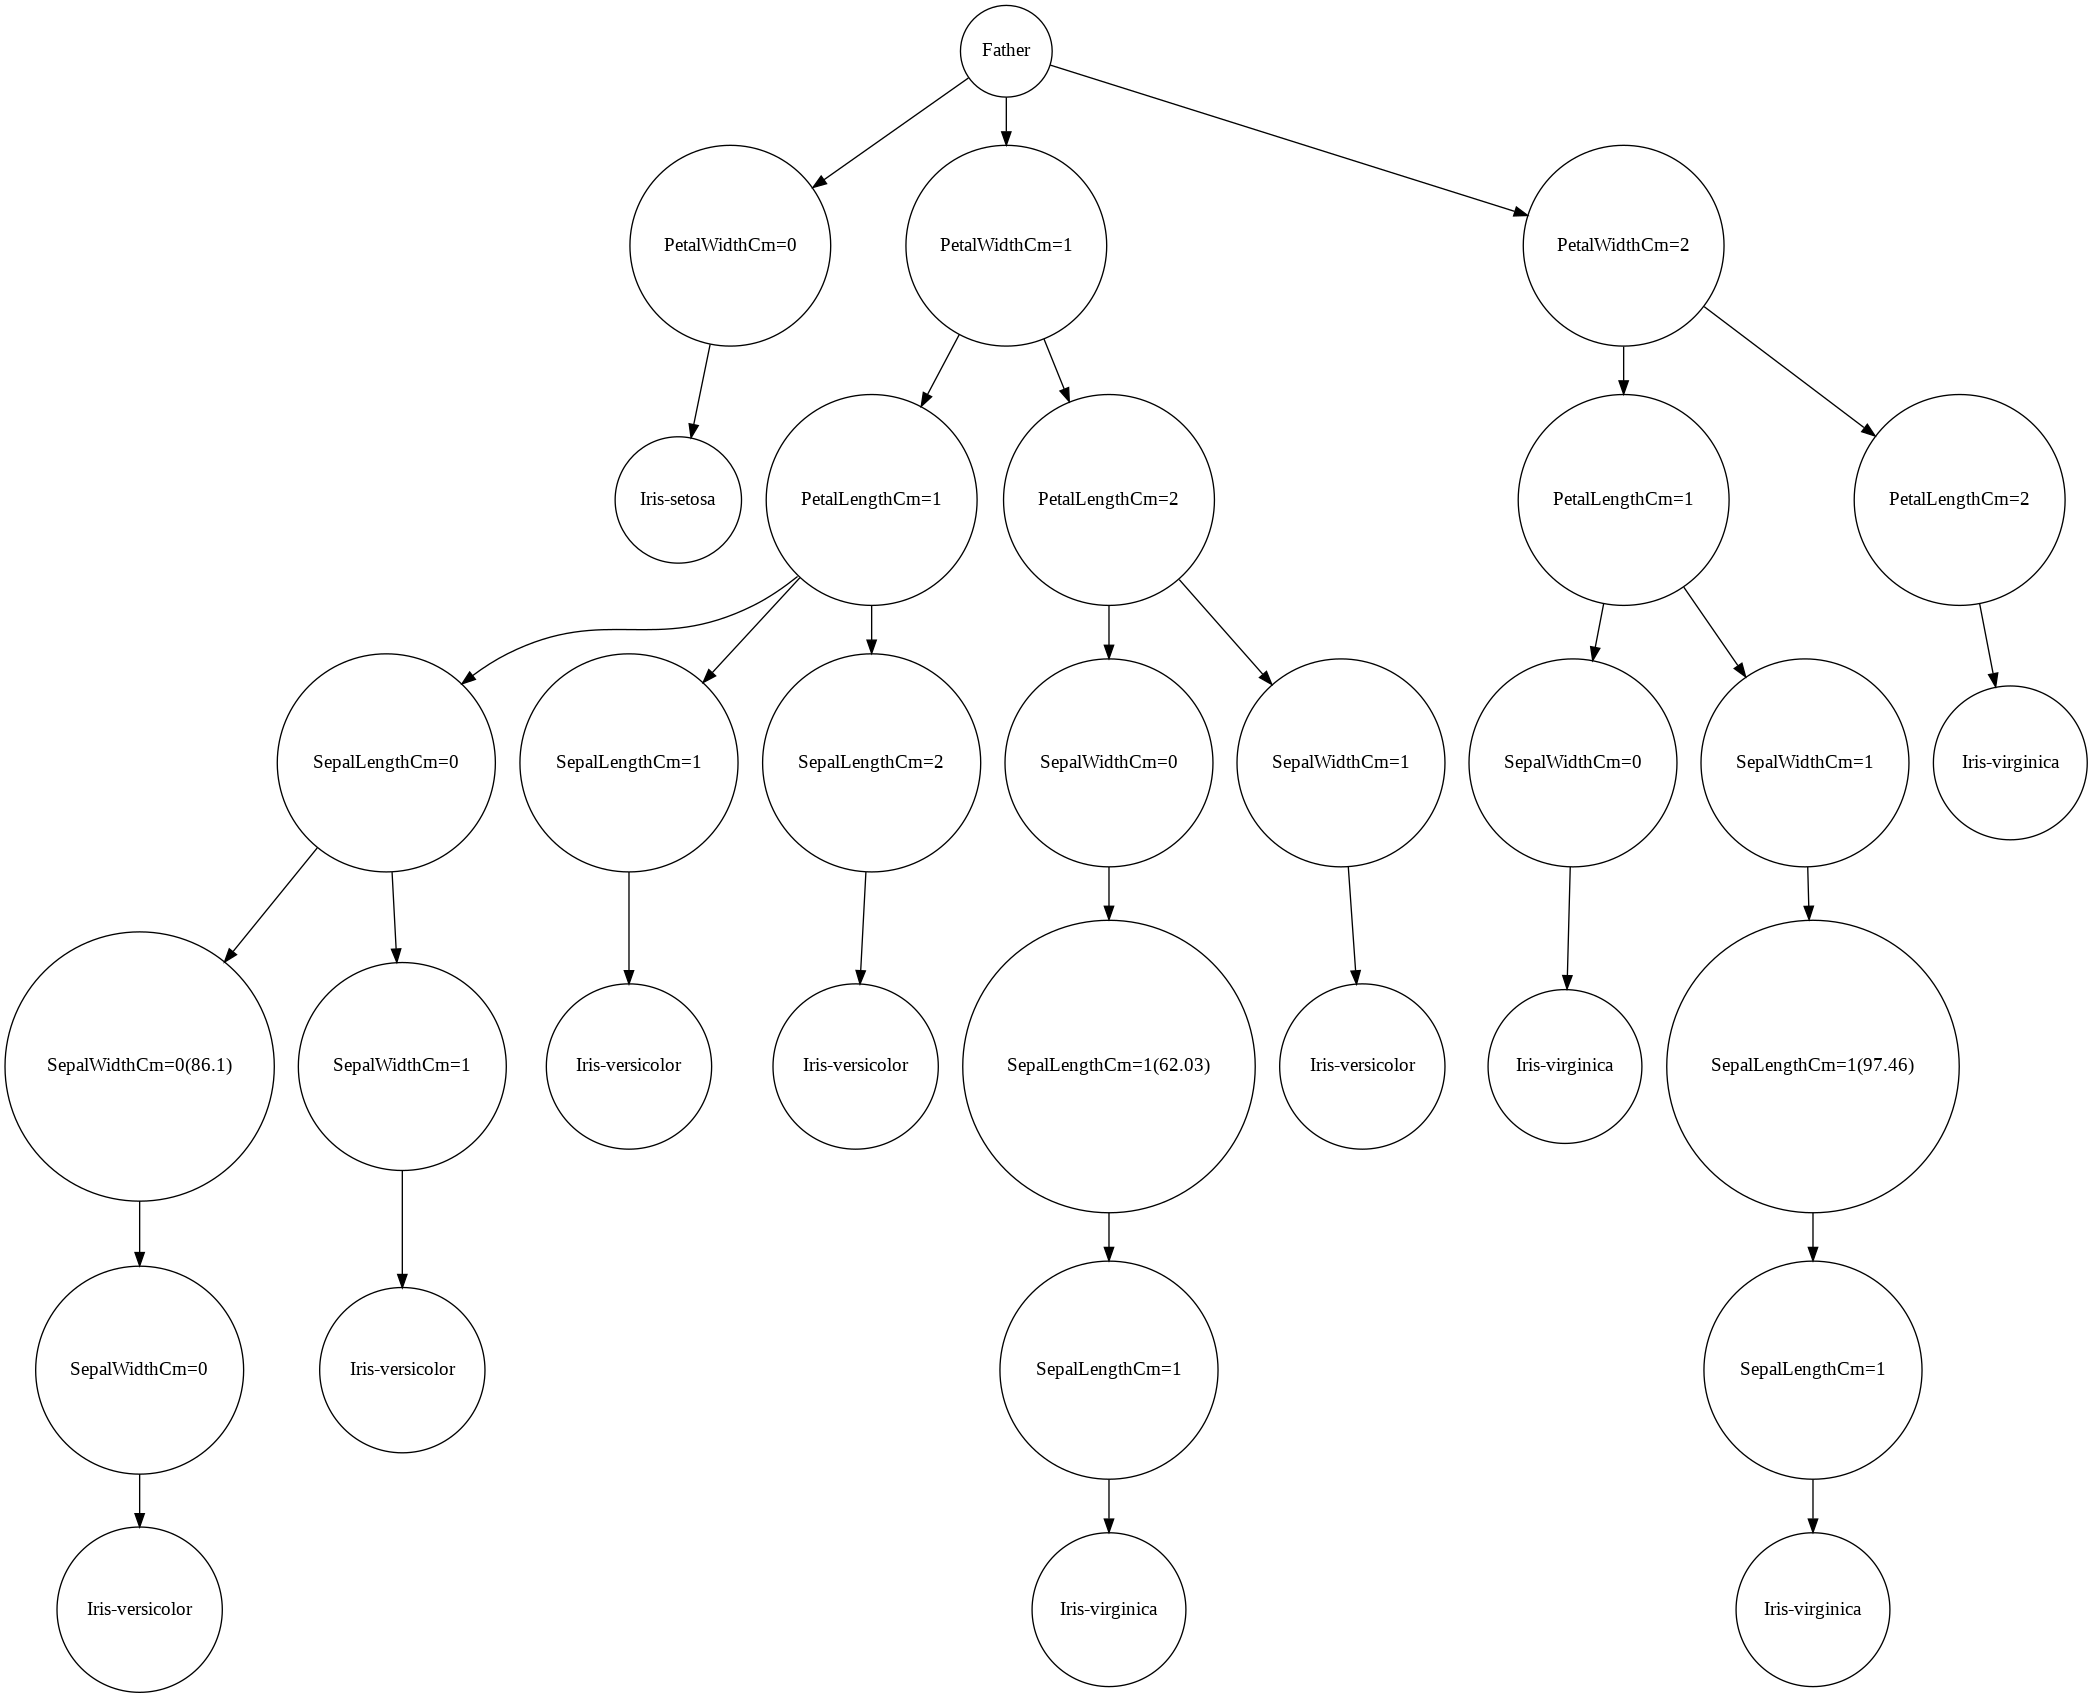

In [ ]:
tree.to_graphviz('tree')
filepath = pathlib.Path('tree')
graphviz.render('dot', 'png', filepath)
Image('tree.png')